### Introduction.

scenario:

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

our superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

### Estimating the value of homes from fixed characteristics

In [6]:
# Import pythin dependencies.  

import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [8]:
# Load the data
house = pd.read_csv('./housing.csv')

In [14]:
# Let's have look at the data 
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,lnSalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,12.247699
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,12.109016
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,12.317171
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,11.849405
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,12.429220


In [15]:
# Let's see all the features(columns) in the data 
house.columns

Index([u'Id', u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea',
       u'Street', u'Alley', u'LotShape', u'LandContour', u'Utilities',
       u'LotConfig', u'LandSlope', u'Neighborhood', u'Condition1',
       u'Condition2', u'BldgType', u'HouseStyle', u'OverallQual',
       u'OverallCond', u'YearBuilt', u'YearRemodAdd', u'RoofStyle',
       u'RoofMatl', u'Exterior1st', u'Exterior2nd', u'MasVnrType',
       u'MasVnrArea', u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual',
       u'BsmtCond', u'BsmtExposure', u'BsmtFinType1', u'BsmtFinSF1',
       u'BsmtFinType2', u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF',
       u'Heating', u'HeatingQC', u'CentralAir', u'Electrical', u'1stFlrSF',
       u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea', u'BsmtFullBath',
       u'BsmtHalfBath', u'FullBath', u'HalfBath', u'BedroomAbvGr',
       u'KitchenAbvGr', u'KitchenQual', u'TotRmsAbvGrd', u'Functional',
       u'Fireplaces', u'FireplaceQu', u'GarageType', u'GarageYrBlt',
       u'GarageFinish',

In [9]:
# Check out the shape
house.shape

(1460, 81)

In [10]:
# get rid of non-residential houses
print house.MSZoning.value_counts(dropna=False)
house = house[house.MSZoning.isin(['RL','RM','RP','RH'])]
print house.shape

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64
(1385, 81)


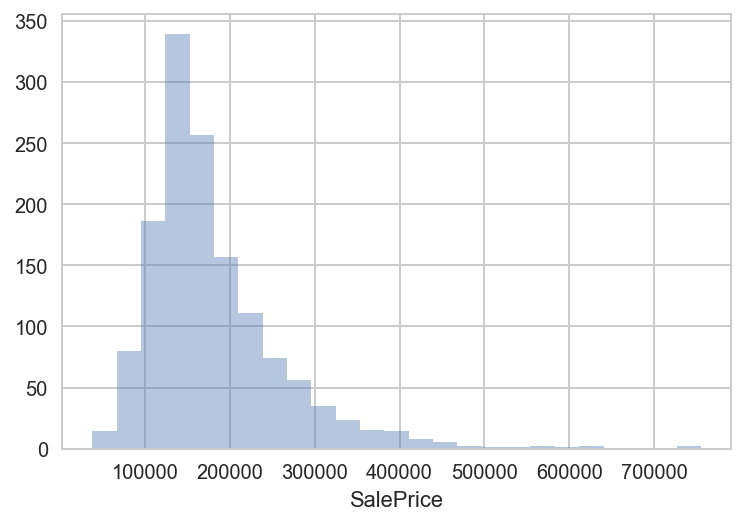

In [11]:
# look at the distribution of sale price
# skewed right
sns.distplot(house.SalePrice, kde=False, bins=25)

In [13]:
# No Extreme outliers
house.SalePrice.describe()

count      1385.000000
mean     180136.283032
std       79906.363281
min       37900.000000
25%      129000.000000
50%      160000.000000
75%      212900.000000
max      755000.000000
Name: SalePrice, dtype: float64

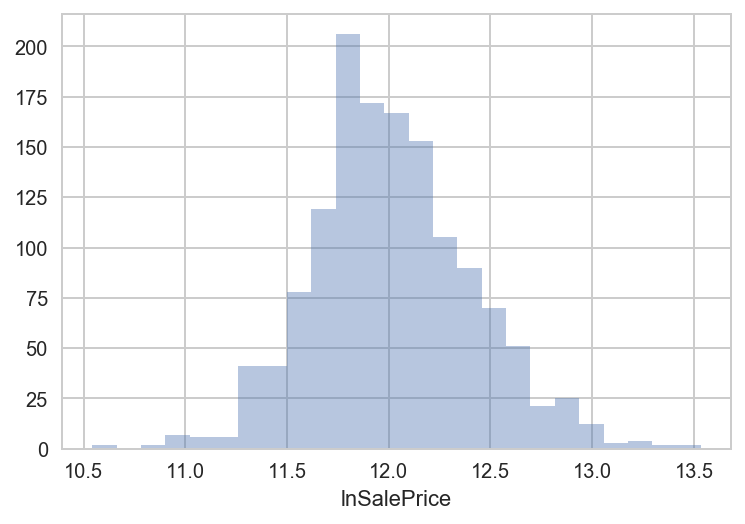

In [12]:
# Making the sale price distribution normal by using log function
house['lnSalePrice'] = np.log(house.SalePrice+1)
sns.distplot(house.lnSalePrice, kde=False, bins=25)

In [17]:
# Calculate how old a house is when it was sold.
house['YrAgeWhenSold'] = (house.YrSold + (house.MoSold-1)/12.) - house.YearBuilt

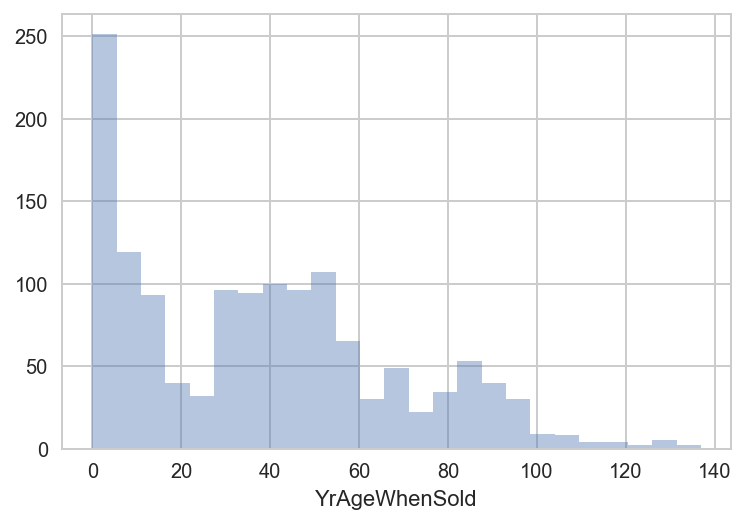

In [18]:
sns.distplot(house.YrAgeWhenSold, kde=False, bins=25)

In [19]:
# Let's have look at the different year sold 

# There is a uniform number of houses sold in the 5 different years in the data set .
# 2010 will be the testing data set
print house.YrSold.value_counts()

2009    321
2007    313
2006    299
2008    288
2010    164
Name: YrSold, dtype: int64


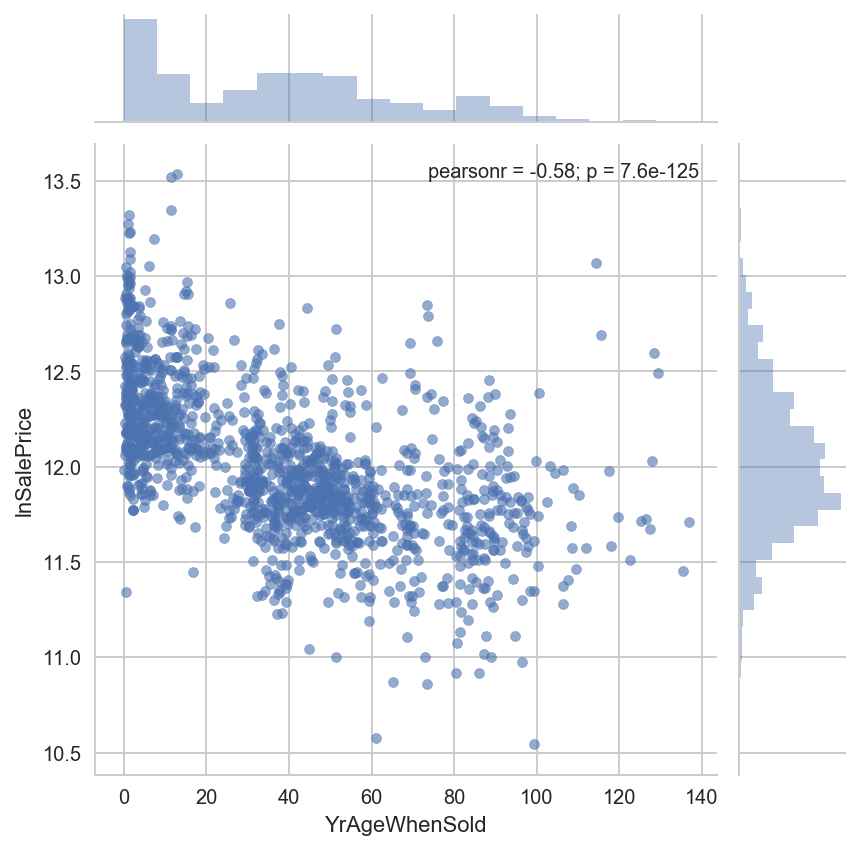

In [20]:
# plot the age of the house vs. the log sale price
# There is a very small negative corelation 

# that could mean that the sale price is higher for newer houses and visa-versa
sns.jointplot(house.YrAgeWhenSold, house.lnSalePrice, joint_kws=dict(s=25, alpha=0.6))

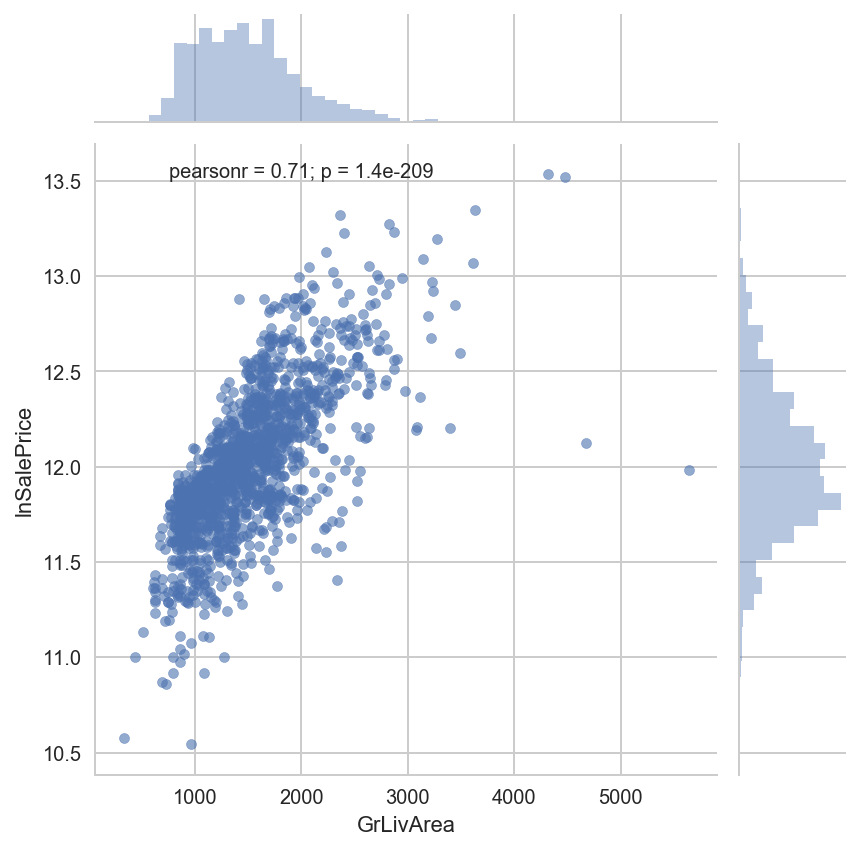

In [21]:
# the liveable area vs. the log sale price 

# A strong positive correlation that indicates that higher area will result in higher sale price and visa-versa.
sns.jointplot(house.GrLivArea, house.lnSalePrice, joint_kws=dict(s=25, alpha=0.6))

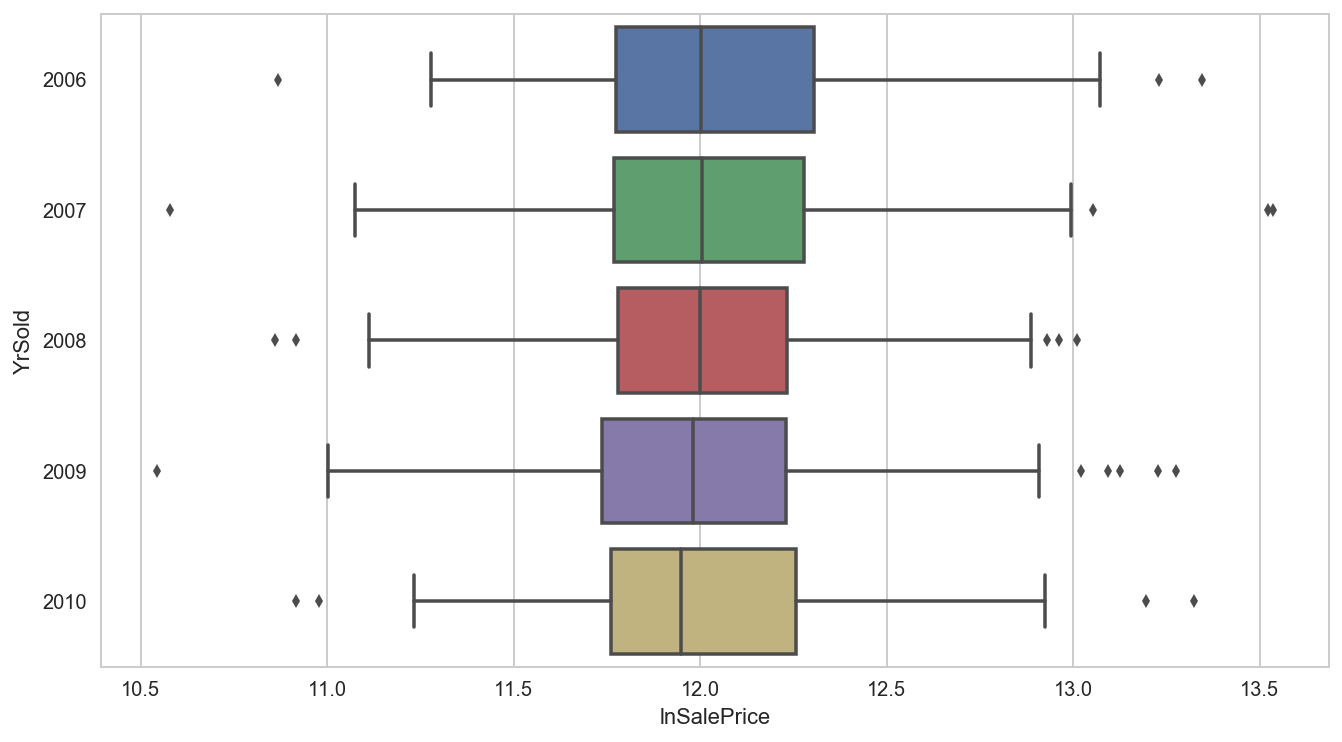

In [22]:
# look at the log sale price by year.
#Can not infer alot here 
fig, ax = plt.subplots(figsize=(11,6))
sns.boxplot(x='lnSalePrice', y='YrSold', data=house, orient='h', ax=ax)
plt.show()

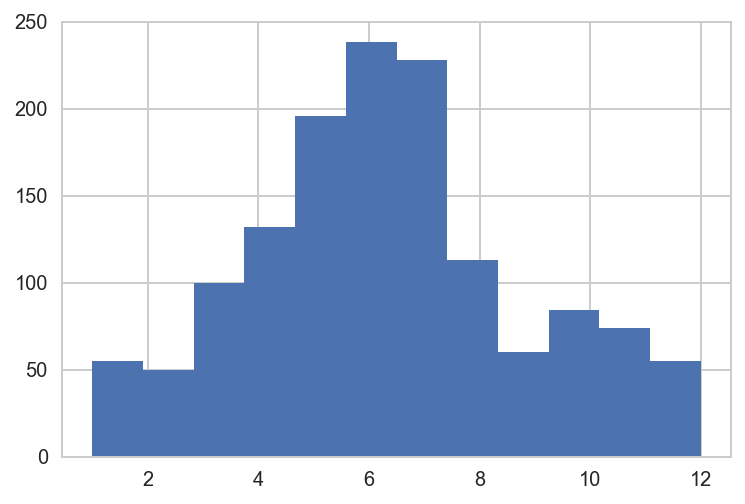

In [23]:
# Let's see house sales in a year . Which month has the most activity .

# Mid year has alot of houses sold .
house.MoSold.hist(bins=12)


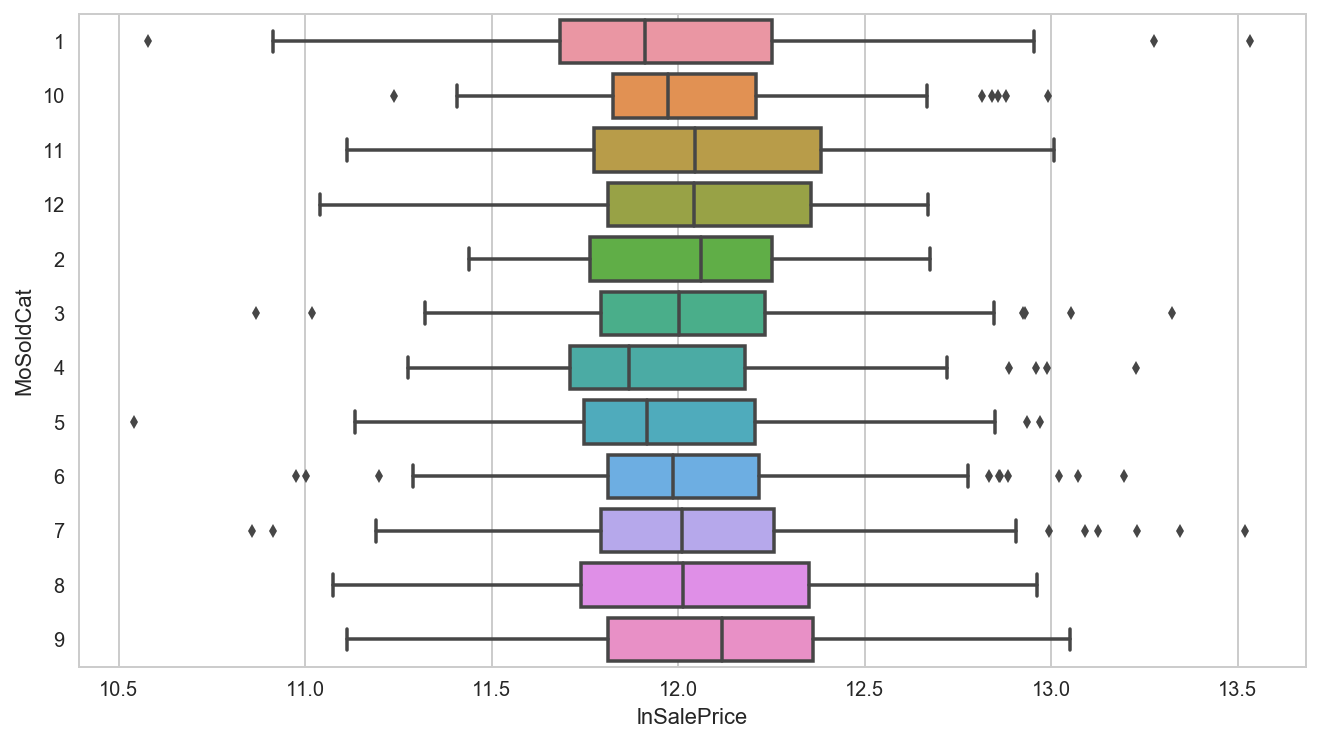

In [25]:
# look at the log sale price by month.
# Not much infered here.
house['MoSoldCat'] = house.MoSold.map(lambda x: str(x))
fig, ax = plt.subplots(figsize=(11,6))
sns.boxplot(x='lnSalePrice', y='MoSoldCat', data=house, orient='h', ax=ax)
plt.show()

In [31]:
# Let's check the null values
nulls = house.isnull().sum()[house.isnull().sum() > 0]

nulls

LotFrontage      251
Alley           1320
MasVnrType         5
MasVnrArea         5
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      641
GarageType        79
GarageYrBlt       79
GarageFinish      79
GarageQual        79
GarageCond        79
PoolQC          1378
Fence           1108
MiscFeature     1333
dtype: int64

In [32]:
# Lots of variables have nulls. Some are continuous, others categorical.
# I wrote a function to fill in both. The categorical ones can be filled
# with "None" because that's what the NA means (based on the data description
# file). A few of the continuous ones can be filled with 0 as that is their 
# meaning.

# I am dropping Electrical, PoolQC, and Id. The first two have no variance - 
# useless variables. The Id is just an identifier of the house.
def col_filler(df, col, fillval='None'):
    df.loc[df[col].isnull(), col] = fillval
    return df

none_fill_cols = ['GarageType','GarageFinish','GarageQual','GarageCond','Fence',
                  'FireplaceQu','BsmtFinType2','BsmtFinType1','BsmtExposure',
                  'BsmtCond','BsmtQual','MasVnrType','MiscFeature']

zero_fill_cols = ['Alley','LotFrontage','MasVnrArea']

drop_rows = ['Electrical']
drop_cols = ['PoolQC','Id']


In [33]:
for col in none_fill_cols:
    house = col_filler(house, col, fillval='None')
    
for col in zero_fill_cols:
    house = col_filler(house, col, fillval=0.)
    
for col in drop_rows:
    house = house[~house[col].isnull()]
    
for col in drop_cols:
    house.drop(col, axis=1, inplace=True)

In [34]:
# Find out which variables remain that have null values.
nulls = house.isnull().sum()[house.isnull().sum() > 0]
nulls

GarageYrBlt    79
dtype: int64

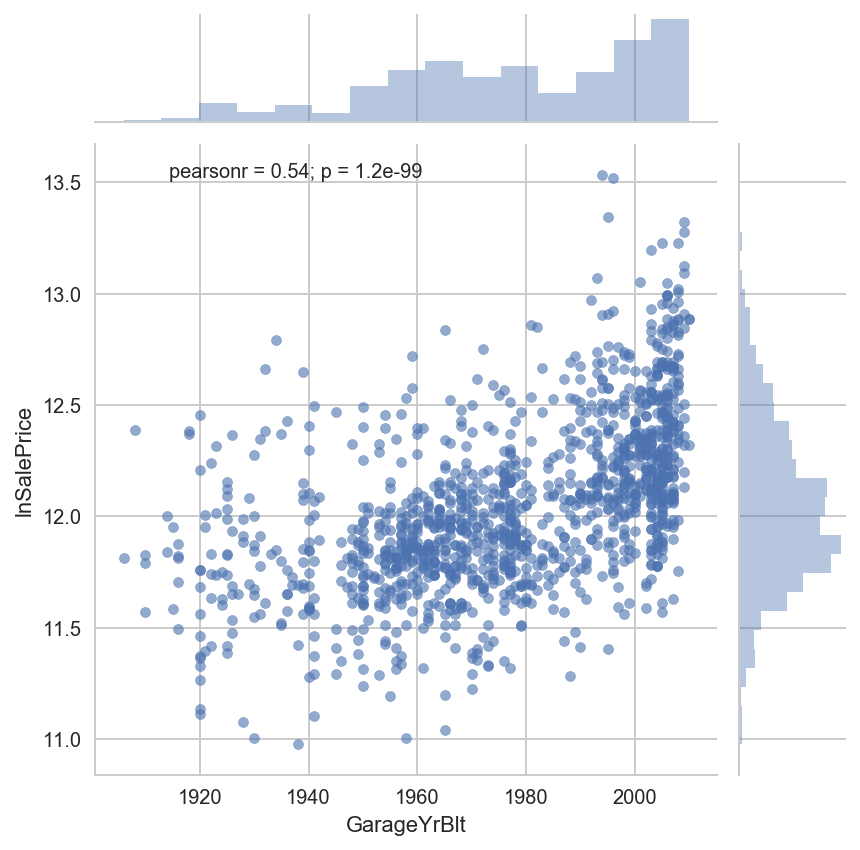

In [35]:
sns.jointplot(house.GarageYrBlt, house.lnSalePrice, joint_kws=dict(s=25, alpha=0.6))

In [36]:
# Drop it cause it has alot of missing values . 
house.drop('GarageYrBlt', axis=1, inplace=True)

In [37]:
# From the descriptions we know 
#MSSubClass: Identifies the type of dwelling involved in the sale.
# Not very insightful for our problem.

house.drop('MSSubClass', axis=1, inplace=True)

In [38]:
# find the proportion of the majority class
# Drop features that don't have any variance.
# If a feature is the same value for more than 95% of observations,

def proportion_majority(df, col):
    max_count = df[col].value_counts().max()
    return float(max_count)/df.shape[0]

In [41]:
props = [[col,proportion_majority(house, col)] for col in house.columns]
props = pd.DataFrame(props2, columns=['feature','majority'])

In [42]:
# columns where the proportion of the majority class is greater than 95%
props[props.majority > 0.95]

,feature,majority
3,Street,0.997110
4,Alley,0.953035
7,Utilities,0.999277
12,Condition2,0.989884
20,RoofMatl,0.981214
37,Heating,0.977601
43,LowQualFinSF,0.984104
50,KitchenAbvGr,0.951590
66,3SsnPorch,0.982659
68,PoolArea,0.994942


In [44]:
# remove the features with minimal variance.
prop_remove_cols = props[props.majority > 0.95].feature.values
h = house.drop(prop_remove_cols, axis=1)

In [45]:
# dropping for the sake of simplicity.

# combine the basement sqft measures
h['BsmtFinSF'] = h.BsmtFinSF1 + h.BsmtFinSF2
h.drop(['Exterior2nd','BsmtFinType2','TotalBsmtSF','BsmtFinSF1',
        'BsmtFinSF2'], axis=1, inplace=True)


In [46]:
# these need to be renamed for patsy
h.rename(columns={'2ndFlrSF':'SecondFlrSF', '1stFlrSF':'FirstFlrSF'}, inplace=True)

In [47]:
# things about property that can be renovated or are in general related to "quality"
# or "condition" in some way. 
changeable = ['OverallCond','RoofStyle','Exterior1st','ExterCond',
              'BsmtCond','HeatingQC','CentralAir','Electrical',
              'GarageFinish','GarageCond','PavedDrive','Functional',
              'OverallQual','ExterQual','BsmtQual','GarageQual','KitchenQual',
              'FireplaceQual','YearRemodAdd']

In [48]:
# make a formula for patsy predicting log sale price from the fixed features. 
# MANY of these are categorical, so there will be a substantial number of columns.
# I have specifically encoded the years and months as categorical variables.
static_f = '''
lnSalePrice ~ MSZoning + LotFrontage + LotArea + LotShape + LandContour + LotConfig + 
LandSlope + Neighborhood + Condition1 + BldgType + HouseStyle + 
YearBuilt + MasVnrType + MasVnrArea + Foundation + 
BsmtExposure + BsmtFinType1 + BsmtUnfSF + FirstFlrSF + SecondFlrSF + 
GrLivArea + BsmtFullBath + BsmtHalfBath + FullBath + HalfBath + BedroomAbvGr + 
TotRmsAbvGrd + Fireplaces + GarageType + SaleCondition + SaleType +
GarageCars + GarageArea + WoodDeckSF + OpenPorchSF + 
EnclosedPorch + ScreenPorch + Fence + C(YrSold) + C(MoSold) + YrAgeWhenSold + BsmtFinSF -1
'''

In [49]:
import patsy

In [50]:
# get the recent year indices for testing
inds_recent = h.YrSold == 2010

In [51]:
# Make the X, y from formula
y, X = patsy.dmatrices(static_f, data=h, return_type='dataframe')
y = y.values.ravel()
print y.shape, X.shape

(1384,) (1384, 137)


In [55]:
# Standardize X before splitting
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Xs = ss.fit_transform(X)

In [66]:
# make training and testing set (test is 2010)
Xtr, Xte = Xs[~inds_recent], Xs[inds_recent]
ytr, yte = y[~inds_recent], y[inds_recent]

In [57]:
Xtr = pd.DataFrame(Xtr, columns=X.columns)
Xte = pd.DataFrame(Xte, columns=X.columns)

In [58]:
print Xtr.shape, Xte.shape

(1220, 137) (164, 137)


In [59]:
# Total of 137 features thus we can use lasso for feature selection during the modeling. 


In [67]:
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(n_alphas=300, cv=10, verbose=1)
lasso_cv.fit(Xtr, ytr)


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=300, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=1)

In [68]:
# create a plot of the mean CV MSE, and some 
# bands for the standard deviation of MSE, plot them
# along the alphas. 
# plotting a line where the best alpha was found.
mean_mse = np.array([np.mean(x) for x in lasso_cv.mse_path_])
std_mse = np.array([np.std(x) for x in lasso_cv.mse_path_])
alphas = lasso_cv.alphas_

best alpha =  0.00426973981019


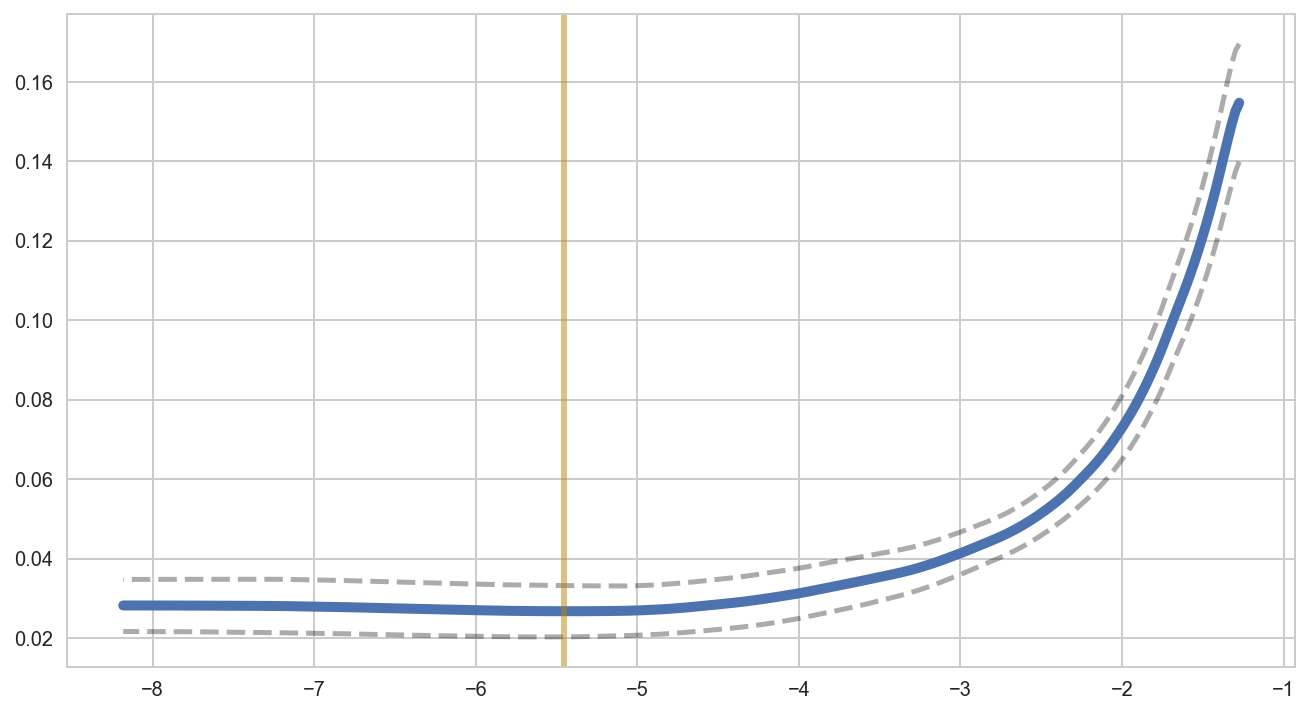

In [69]:
std_plus = mean_mse+std_mse/2.
std_minus = mean_mse-std_mse/2.

fig, ax = plt.subplots(figsize=(11,6))

ln_alphas = np.log(alphas)

ax.plot(ln_alphas, mean_mse, lw=5)

ax.plot(ln_alphas, std_plus, lw=2.5, ls='dashed', c='black', alpha=0.33)
ax.plot(ln_alphas, std_minus, lw=2.5, ls='dashed', c='black', alpha=0.33)

min_mse = np.min(mean_mse)
best_alpha = np.where(mean_mse == min_mse)[0][-1]

ax.axvline(x=ln_alphas[best_alpha], lw=3, c='darkgoldenrod', alpha=0.5)
print 'best alpha = ', np.exp(ln_alphas[best_alpha])
plt.show()

In [70]:
# Put the features and coefs into a dataframe
# sort by magnitude
lasso_feat = pd.DataFrame(dict(feature=X.columns, coef=lasso_cv.coef_, abscoef=np.abs(lasso_cv.coef_)))
lasso_feat.sort_values('abscoef', inplace=True, ascending=False)
lasso_feat[lasso_feat.coef != 0.]

,abscoef,coef,feature
121,0.129324,0.129324,GrLivArea
129,0.058709,0.058709,GarageCars
30,0.045825,0.045825,Neighborhood[T.NridgHt]
135,0.033360,-0.033360,YrAgeWhenSold
116,0.032011,0.032011,YearBuilt
20,0.029962,0.029962,Neighborhood[T.Crawfor]
128,0.028497,0.028497,Fireplaces
36,0.026888,0.026888,Neighborhood[T.StoneBr]
73,0.020255,-0.020255,BsmtFinType1[T.None]
21,0.019840,-0.019840,Neighborhood[T.Edwards]



There are 72 selected features which are important to estimate the price , some of them are :
-livable area, cars in garage, neighborhood, age when sold, fireplaces, etc.

These coefficients are a bit hard to interpret:
1. They are in terms of standard deviations of the predictor.
2. The target is in log terms (orders of magnitude)

So basically a coefficient is saying -for a 1 standard deviation increase in
this predictor, there will be x increase in orders of magnitude of the sale price.

In [71]:
lasso_cv.alpha_

0.0042697398101869165

In [72]:
from sklearn.linear_model import Lasso
best_lasso = Lasso(alpha=lasso_cv.alpha_)
best_lasso.fit(Xtr, ytr)

Lasso(alpha=0.0042697398101869165, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [73]:
# Testing on 2010 we see that we have an R2 of 89.
# 89% of variance in price explained is quite good.
best_lasso.score(Xte, yte)

0.89060900902157525

### Determine any effects of changeable property characteristics on variance in price unexplained by the fixed characteristics

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [75]:
# get out the residuals for training and testing, in terms of dollars.
tr_resids = np.exp(ytr) - np.exp(best_lasso.predict(Xtr))
te_resids = np.exp(yte) - np.exp(best_lasso.predict(Xte))

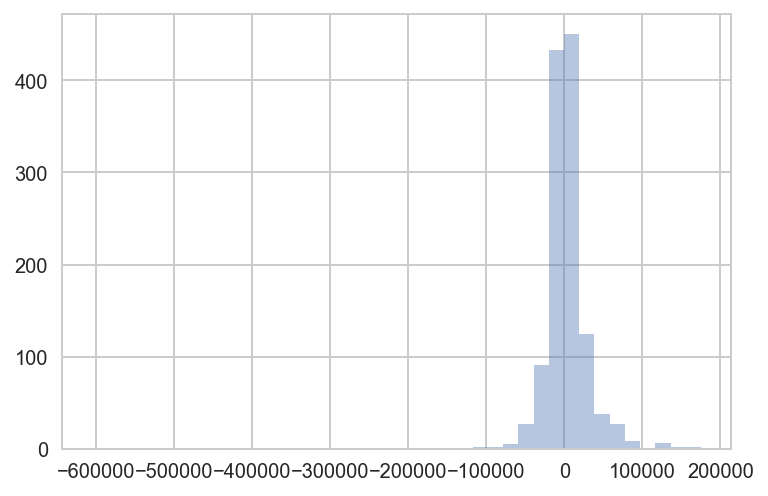

In [76]:
# looks like there is a bad outlier in there...
sns.distplot(tr_resids, kde=False, bins=40)

In [77]:
# there is definitely a wild prediction in there...
print tr_resids.min()
print stats.scoreatpercentile(tr_resids, 0.5)

-604765.859219
-67448.8792951


In [78]:
# truncate the minimum at -70000:
tr_resids[tr_resids < -70000] = -70000

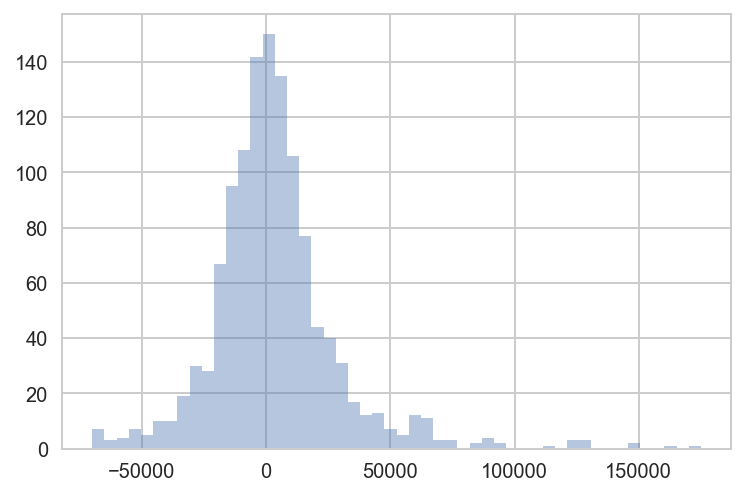

In [79]:
sns.distplot(tr_resids, kde=False)

In [80]:
# things that could be done via renovation:
renovations = ['RoofStyle','Exterior1st','ExterCond',
              'BsmtCond','HeatingQC','CentralAir','Electrical',
              'GarageFinish','GarageCond','PavedDrive',
              'ExterQual','BsmtQual','GarageQual','KitchenQual',
              'FireplaceQu']
# Note that I have omitted the "overall" quality and condition ones. 
# Those aren't really specific renovations - I want to pinpoint the specific
# things that have an effect on expected price, and by how much. Overall
# is just too vague.

In [81]:
renovation_f = '~ '+' + '.join(renovations)+' -1'

In [82]:
# make the renovation predictor matrix
Xren = patsy.dmatrix(renovation_f, data=h, return_type='dataframe')
print Xren.shape

(1384, 67)


In [87]:
# standardize it
ss = StandardScaler()
Xrens = ss.fit_transform(Xren)

In [88]:
# split by year again
Xren_tr, Xren_te = Xrens[~inds_recent], Xrens[inds_recent]

In [89]:
# Going to search over the ridge this time. Instead of going
# for feature elimination I am looking to mitigate multicollinearity
# and keep all the renovations in.


In [90]:
from sklearn.linear_model import RidgeCV

ren_cv = RidgeCV(alphas=np.logspace(-5,4,300), cv=10)
ren_cv.fit(Xren_tr, tr_resids)


RidgeCV(alphas=array([  1.00000e-05,   1.07177e-05, ...,   9.33039e+03,   1.00000e+04]),
    cv=10, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=False)

In [91]:
ren_cv.alpha_

78.15856707684091

In [92]:
ren_cv.score(Xren_tr, tr_resids)

0.22492956034042622

In [93]:
ren_cv.score(Xren_te, te_resids)

0.22400745270213662

We are explaining 22% of the variance in the remaining variance in price 
NOT explained by the fixed characteristics of the house.
Notably, we are preforming basically the same on training and testing. This
is great.It means our model generalizes very well out of sample. Despite
the R2 being low, this alone makes me trust the variance we are explaining.

In [94]:
renovation_coefs = pd.DataFrame(dict(coef=ren_cv.coef_,
                                     abscoef=np.abs(ren_cv.coef_),
                                     feature=Xren.columns))
renovation_coefs.sort_values('abscoef', ascending=False, inplace=True)
renovation_coefs.head(25)

,abscoef,coef,feature
61,8214.671200,-8214.671200,KitchenQual[T.TA]
60,5927.627527,-5927.627527,KitchenQual[T.Gd]
49,5321.758870,-5321.758870,ExterQual[T.TA]
51,4335.661180,-4335.661180,BsmtQual[T.Gd]
58,3914.356472,-3914.356472,GarageQual[T.TA]
8,3429.323012,3429.323012,Exterior1st[T.BrkFace]
53,3244.614579,-3244.614579,BsmtQual[T.TA]
48,3120.899006,-3120.899006,ExterQual[T.Gd]
54,2966.739989,-2966.739989,GarageQual[T.Fa]
59,2492.598183,-2492.598183,KitchenQual[T.Fa]


Here sorting by coef magnitude for the 2nd model.
What does this say? Well we are predicting the dollar amount now,
but note it is in terms of ERRORS of the first model.
so for example, if the first model overestimated the price for a 
house, then the error in price (residual) would be negative. 
We are predicting those residuals. 
Luckily, positive and negative still means the same thing. Our
3429 coef on Exterior Brick face means that this feature is "worth"
3429 dollars (it is estimated to be 3429 dollars greater).

Many of these features would do well to be converted onto a numeric
scale to make them more interpretable. If i had more time I would
(such as the good, average, bad quality ones).

We can use these features to evaluate how much in dollars a renovation
is worth. For example if we wanted to upgrade a kitchen from "fair" (TA)
to "good" (Gd) then we would evaluate the differences in their coefficients.
The good kitchen is less negative than the average. The difference between
them is an estimate of how much value we would gain making that change.